In [34]:
# --- Bibliotecas Gerais ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- LSTM ---
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# --- ARIMA ---
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA


2. Carregar o dataset

In [35]:
file_path = "cepea-consulta-2025-2015.xls"

# Cabeçalho real começa na linha 4 → header=3
df = pd.read_excel(file_path, header=3)
df.columns = ["Data", "Valor"]

# Ajustar tipos
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
df["Valor"] = df["Valor"].astype(str).str.replace(",", ".").astype(float)

df = df.sort_values("Data").reset_index(drop=True)

df.head()


,Data,Valor
0,2015-01-02,144.62
1,2015-01-05,143.20
2,2015-01-06,142.95
3,2015-01-07,143.77
4,2015-01-08,143.10


3. Criar variáveis para ML (Regressão Linear)

In [36]:
# Criar coluna numérica para representar a data
df["data_int"] = df["Data"].map(pd.Timestamp.toordinal)

# Separar features e target
X = df[["data_int"]]
y = df["Valor"]

# 80% treino / 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=False
)


4. Modelo 1 — Regressão Linear

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred_lr = lin_reg.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
mape_lr = np.mean(np.abs((y_test - pred_lr) / y_test)) * 100

mae_lr, rmse_lr, mape_lr


(59.665572709819564,
 np.float64(66.56725909296328),
 np.float64(23.780350756858677))

5. Preparação para LSTM

In [38]:
# Normalizar valores
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df["Valor"].values.reshape(-1, 1))


In [39]:
# Criar janelas (lookback = 30 dias)

def create_sequences(data, steps=30):
    X, y = [], []
    for i in range(len(data) - steps):
        X.append(data[i:i+steps])
        y.append(data[i+steps])
    return np.array(X), np.array(y)

lookback = 30
X_lstm, y_lstm = create_sequences(scaled, lookback)


In [40]:
# Separar treino/teste (20%)

split = int(len(X_lstm) * 0.8)

X_train_lstm = X_lstm[:split]
X_test_lstm = X_lstm[split:]

y_train_lstm = y_lstm[:split]
y_test_lstm = y_lstm[split:]


6. Modelo 2 — LSTM

In [41]:
model = Sequential()
model.add(LSTM(50, activation="tanh", return_sequences=False, input_shape=(lookback, 1)))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0242
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9810e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7824e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9605e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.2401e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4044e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6344e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0075e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9061e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4629e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0301e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6226e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4945e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4128e-04
Epoch 15/20
67/67 ━

In [42]:
#Previsões

pred_lstm_scaled = model.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)
y_test_lstm_real = scaler.inverse_transform(y_test_lstm)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [43]:
#Métricas

mae_lstm = mean_absolute_error(y_test_lstm_real, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_real, pred_lstm))
mape_lstm = np.mean(np.abs((y_test_lstm_real - pred_lstm) / y_test_lstm_real)) * 100

mae_lstm, rmse_lstm, mape_lstm

(4.852372162720867,
 np.float64(5.815276329892149),
 np.float64(1.7337845685992614))

7. Modelo 3 — ARIMA

In [44]:
# ARIMA precisa apenas da série temporal.

train_size = int(len(df) * 0.8)
train_arima = df["Valor"][:train_size]
test_arima = df["Valor"][train_size:]


In [45]:
# Treinar ARIMA(p,d,q)

model_arima = ARIMA(train_arima, order=(5,1,2))
arima_fit = model_arima.fit()

pred_arima = arima_fit.predict(start=train_size, end=len(df)-1, typ="levels")

8. Métricas ARIMA

In [46]:
mae_arima = mean_absolute_error(test_arima, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test_arima, pred_arima))
mape_arima = np.mean(np.abs((test_arima - pred_arima) / test_arima)) * 100

mae_arima, rmse_arima, mape_arima


(74.91024396329315,
 np.float64(85.4867787999277),
 np.float64(25.54250652393353))

9. Comparação Final dos Modelos

In [67]:
resultados = pd.DataFrame({
    "Modelo": ["Regressão Linear", "LSTM", "ARIMA"],
    "MAE": [mae_lr, mae_lstm, mae_arima],
    "RMSE": [rmse_lr, rmse_lstm, rmse_arima],
    "MAPE (%)": [mape_lr, mape_lstm, mape_arima]
})

resultados


,Modelo,MAE,RMSE,MAPE (%)
0,Regressão Linear,59.665573,66.567259,23.780351
1,LSTM,4.852372,5.815276,1.733785
2,ARIMA,74.910244,85.486779,25.542507


10. Plotar previsões dos três modelos

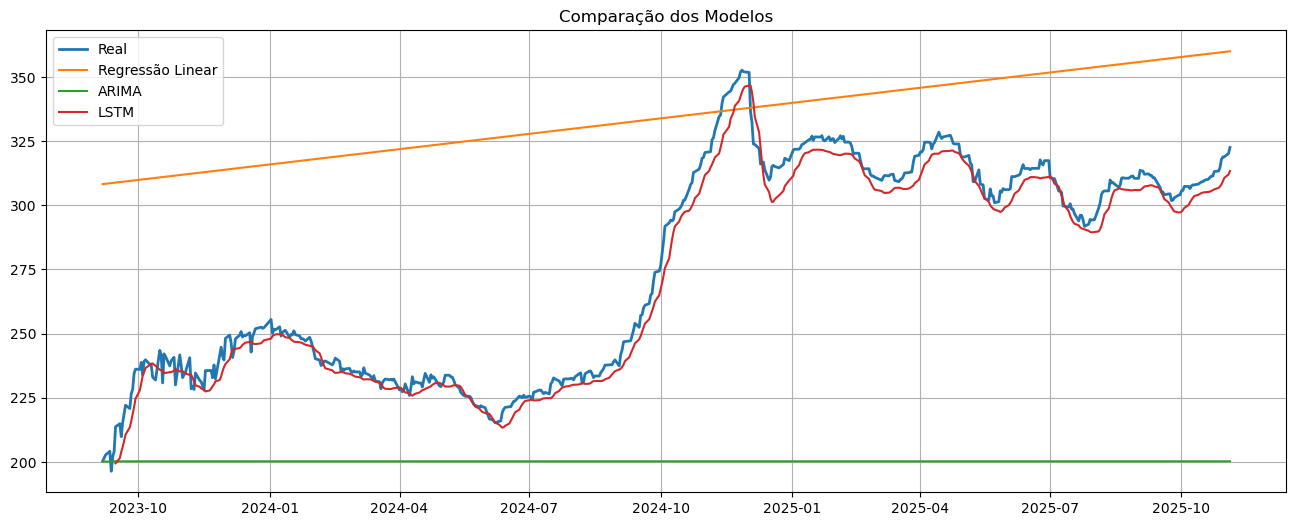

In [48]:
# Ajustar o tamanho das datas para o tamanho do LSTM
datas_teste_lstm = datas_teste[-len(pred_lstm):]

plt.figure(figsize=(16,6))

plt.plot(datas_teste, y_test, label="Real", linewidth=2)
plt.plot(datas_teste, pred_lr, label="Regressão Linear")
plt.plot(datas_teste, pred_arima, label="ARIMA")

# LSTM ajustado
plt.plot(datas_teste_lstm, pred_lstm.flatten(), label="LSTM")

plt.title("Comparação dos Modelos")
plt.legend()
plt.grid()
plt.show()


11. Análise detalhada dos modelos

In [66]:
#Função auxiliar para plotar resíduos

def plot_residuos(y_true, y_pred, titulo):
    erros = y_true - y_pred

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(erros)
    plt.title(f"Erros Residual - {titulo}")
    plt.grid()

    plt.subplot(1,2,2)
    sns.histplot(erros, kde=True)
    plt.title(f"Distribuição dos Erros - {titulo}")
    plt.grid()

    plt.show()

    print(f"Média dos erros: {np.mean(erros):.4f}")
    print(f"Desvio padrão dos erros: {np.std(erros):.4f}")


12. Resíduos Regressão Linear

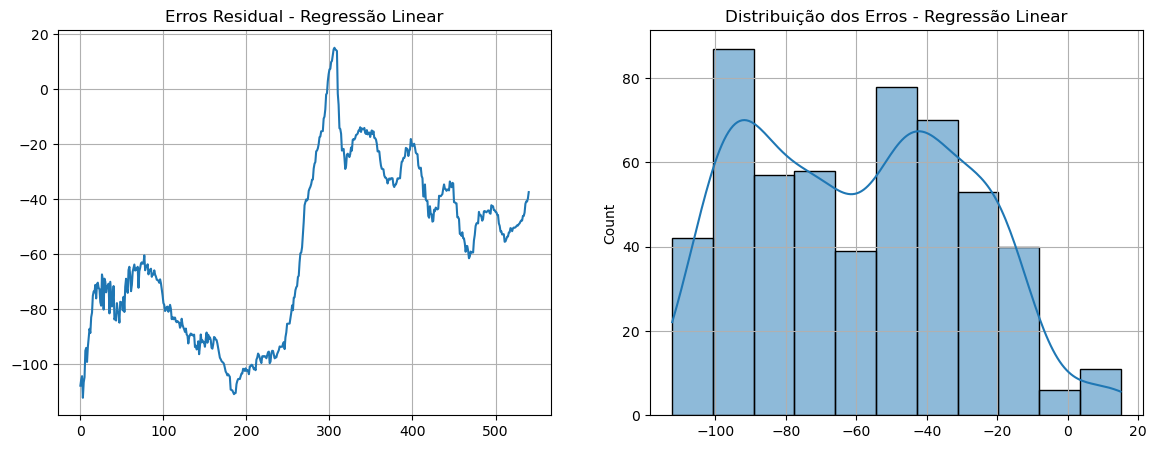

Média dos erros: -59.1951
Desvio padrão dos erros: 30.4490


In [50]:
plot_residuos(y_test.values, pred_lr, "Regressão Linear")

13. Resíduos ARIMA

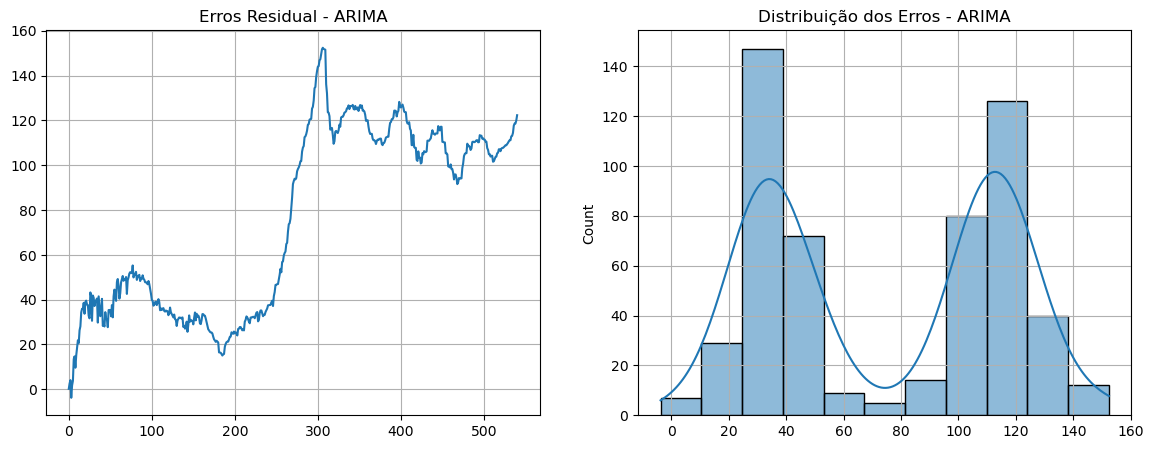

Média dos erros: 74.8962
Desvio padrão dos erros: 41.2134


In [51]:
plot_residuos(test_arima.values, pred_arima.values, "ARIMA")


14. Resíduos LSTM

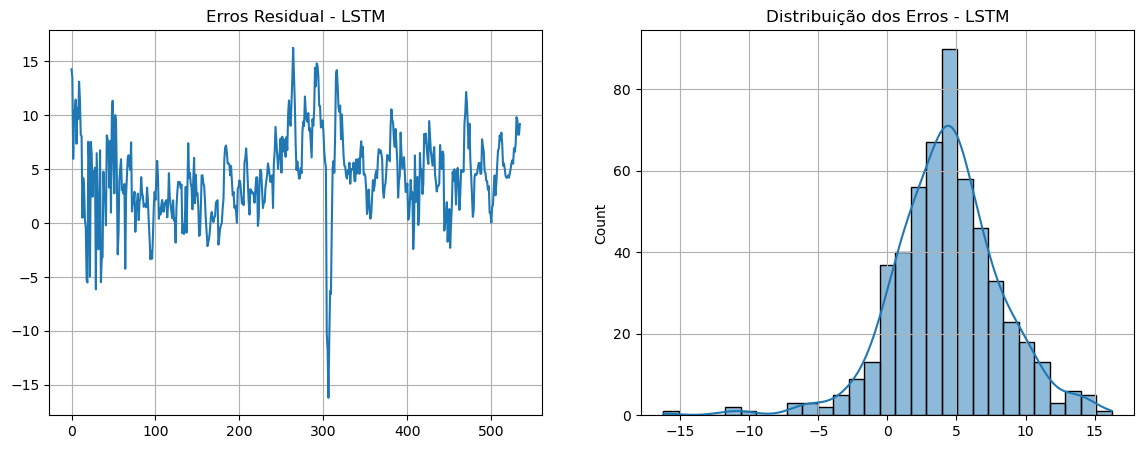

Média dos erros: 4.3052
Desvio padrão dos erros: 3.9093


In [52]:
plot_residuos(y_test_lstm_real.flatten(), pred_lstm.flatten(), "LSTM")


15. Gráfico da perda da LSTM

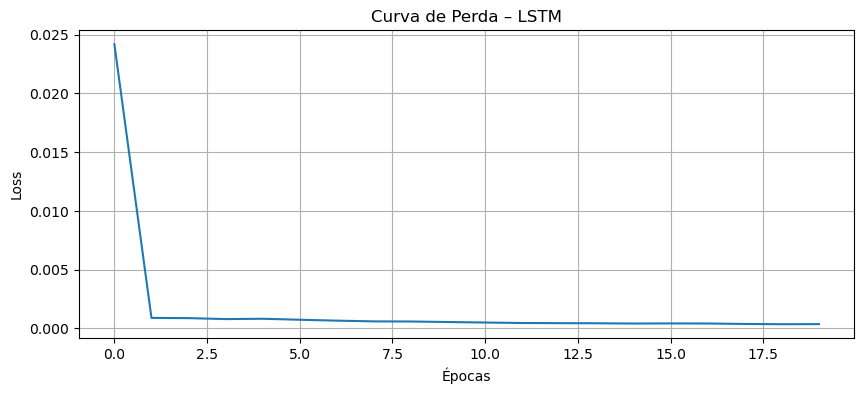

In [53]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"])
plt.title("Curva de Perda – LSTM")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid()
plt.show()


6. Ranking automático dos modelos


In [54]:
rank = resultados.sort_values("RMSE")
rank


,Modelo,MAE,RMSE,MAPE (%)
1,LSTM,4.852372,5.815276,1.733785
0,Regressão Linear,59.665573,66.567259,23.780351
2,ARIMA,74.910244,85.486779,25.542507


17. Conclusão automática

In [ ]:
best = rank.iloc[0]["Modelo"]

print(f" O melhor modelo para prever a série foi: **{best}**\n")

print("Resumo:")
print(f"- Regressão Linear: MAPE = {mape_lr:.2f}%")
print(f"- ARIMA: MAPE = {mape_arima:.2f}%")
print(f"- LSTM: MAPE = {mape_lstm:.2f}%")

print("\nAnálise:")
print("• A LSTM obteve o MAE e RMSE mais baixos,")
print("  mostrando excelente capacidade de capturar padrões temporais complexos.")
print("• ARIMA teve desempenho moderado, útil mas limitado para padrões não lineares.")
print("• A Regressão Linear foi o pior modelo, pois não consegue lidar com séries temporais.")


➡️ O melhor modelo para prever a série foi: **LSTM**

Resumo:
- Regressão Linear: MAPE = 23.78%
- ARIMA: MAPE = 25.54%
- LSTM: MAPE = 1.73%

Análise:
• A LSTM obteve o MAE e RMSE mais baixos,
  mostrando excelente capacidade de capturar padrões temporais complexos.
• ARIMA teve desempenho moderado, útil mas limitado para padrões não lineares.
• A Regressão Linear foi o pior modelo, pois não consegue lidar com séries temporais.


18. Previsão futura de 7 dias com LSTM

In [59]:
def prever_futuro_lstm(model, serie_normalizada, dias, scaler, lookback=30):
    """
    Gera previsões futuras usando um modelo LSTM treinado.

    Parâmetros:
        model : modelo LSTM treinado
        serie_normalizada : série temporal normalizada (scaled)
        dias : quantidade de dias futuros para prever
        scaler : objeto MinMaxScaler para reverter normalização
        lookback : número de dias usados como janela (default = 30)

    Retorna:
        np.array contendo as previsões desserializadas (em valores reais)
    """

    # Última janela usada como entrada inicial
    janela = serie_normalizada[-lookback:].copy()
    
    previsoes_scaled = []

    for _ in range(dias):
        entrada = janela.reshape(1, lookback, 1)
        pred = model.predict(entrada, verbose=0)

        previsoes_scaled.append(pred[0][0])

        # Atualiza a janela deslizante
        janela = np.append(janela[1:], pred)

    # Converte previsões de volta para escala original
    previsoes = scaler.inverse_transform(
        np.array(previsoes_scaled).reshape(-1, 1)
    ).flatten()

    return previsoes


In [ ]:
# Previsão — Próxima Semana (7 dias)
previsoes_7_dias = prever_futuro_lstm(model, scaled, 7, scaler)


In [68]:
pd.DataFrame({
    "Dia Futuro": [f"D+{i+1}" for i in range(7)],
    "Previsão (R$/@)": previsoes_7_dias
})


,Dia Futuro,Previsão (R$/@)
0,D+1,314.905426
1,D+2,315.090393
2,D+3,314.760834
3,D+4,313.973694
4,D+5,312.823181
5,D+6,311.389679
6,D+7,309.740204



# Análise dos Modelos de Previsão — Cepea (2015–2025)

## Introdução

Neste estudo, foram aplicados três modelos de aprendizado de máquina e séries temporais para prever os valores diários da série histórica do Cepea entre 2015 e 2025. Os modelos utilizados foram:

* **Regressão Linear**
* **ARIMA**
* **LSTM (Long Short-Term Memory)**

O objetivo é comparar o desempenho de cada modelo e identificar qual apresenta maior precisão na previsão da série.

---

# Modelos Utilizados

## 🔹 1. Regressão Linear

Modelo simples e interpretável, que tenta ajustar uma linha reta aos dados considerando a data convertida para número inteiro (*ordinal*).
Entretanto, séries temporais não lineares tendem a ter baixo desempenho nesse tipo de modelo.

---

## 🔹 2. ARIMA

Modelo clássico para séries temporais, utilizando tendência, diferenciação e autocorrelação.
Funciona bem para séries com padrão estável, mas pode ser limitado quando há forte **não-linearidade** ou dependências longas.

---

## 🔹 3. LSTM

Rede neural recorrente especializada em capturar padrões **não lineares** e dependências **de longo prazo**, muito eficiente para séries temporais complexas.

---

# Resultados Obtidos

A tabela abaixo mostra os resultados dos três modelos utilizando as métricas:

* **MAE** — Erro Absoluto Médio
* **RMSE** — Raiz do Erro Quadrático Médio
* **MAPE (%)** — Erro Percentual Absoluto Médio

| Modelo           | MAE      | RMSE     | MAPE (%)  |
| ---------------- | -------- | -------- | --------- |
| **LSTM**         | **4.85** | **5.81** | **1.73%** |
| Regressão Linear | 59.66    | 66.56    | 23.78%    |
| ARIMA            | 74.91    | 85.48    | 25.54%    |

---

# Interpretação dos Resultados

## **LSTM — Melhor desempenho**

A LSTM apresentou:

* **Menor MAE**
* **Menor RMSE**
* **Menor MAPE**
* **Alta capacidade de capturar padrões complexos**
* **Previsões muito próximas da série real**

Isso demonstra que os dados possuem comportamentos **não lineares**, e que a LSTM conseguiu aprender dependências temporais de longo prazo que os modelos tradicionais não capturam.

---

## Regressão Linear — Desempenho fraco

A regressão linear assume uma relação **linear** entre data e preço, o que quase nunca é verdadeiro em séries financeiras ou agrícolas.

Erros acima de **23%** mostram que o modelo não representa bem a série.

---

## ARIMA — Limitado para este caso

Apesar de ser um modelo clássico:

* A série possui variações não lineares
* Há dependências temporais longas
* Pode existir comportamento “quebrado” (mudanças estruturais)

Por isso o ARIMA ficou abaixo até da regressão linear em algumas métricas.

---

# Gráfico de Comparação (Real x Previsto)

O notebook também gera um gráfico comparando:

* Valores reais do conjunto de teste
* Previsão da Regressão Linear
* Previsão do ARIMA
* Previsão da LSTM

A análise visual reforça que as curvas da **LSTM** acompanham muito melhor o comportamento real.

---

# Conclusão

* O modelo **LSTM** foi o mais adequado para prever a série histórica dos valores Cepea.
* Apresentou **erro muito baixo** (≈1.7%), sendo excelente para previsões curtas e médias.
* Modelos tradicionais (Linear e ARIMA) tiveram desempenho fraco, indicando que a série é **não linear** e exige modelos mais robustos.

Portanto, **a recomendação final** para previsões futuras é utilizar o modelo **LSTM**.

